In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # for clearness of the output

# S&P 500 companies
tickers = pd.read_csv('tickers2trade.csv')['Symbol'].tolist()
len(tickers)

504

In [14]:
# extract close data locally from datasets

import os

folder = 'data'
directories = ['data/2022', 'data/2023', 'data/2024']

open_data_dict = {}
unavailable_tickers = []

# Loop through each ticker
for ticker in tickers: 
    # Loop through each directory
    curr_data = pd.DataFrame()
    available = True
    for directory in directories:
        # Get the file path
        file_path = os.path.join(directory, f'{ticker}.csv')
        # Read the data
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            unavailable_tickers.append(ticker)
            available = False
            break  # if no current ticker in any years, ignore this ticker
        data = pd.read_csv(file_path, index_col='DateTime', parse_dates=True)
        # Filter data from 9:30 to 4 pm for all days
        data = data.between_time('09:30', '16:00')
        
        # Append the data to the curr_data DataFrame
        if curr_data.empty:
            curr_data = data['Close']
        else:
            curr_data = pd.concat([curr_data, data['Close']])
        
    if not available:
        continue
    curr_data = curr_data[~curr_data.index.duplicated(keep='first')]
    open_data_dict[ticker] = curr_data

# Combine all data into a single DataFrame
close_data = pd.concat(open_data_dict, axis=1)

tickers unavailable: ['GEV', 'KVUE', 'SW', 'VLTO', 'SOLV', 'AMTM', 'BRK-B']

In [2]:
# loading prepared data
close_data = pd.read_csv('close_data.csv', index_col='DateTime', parse_dates=True)
close_data_prepared = close_data.ffill()

In [3]:
def get_uid_factor(close_data: pd.DataFrame, freq='M') -> pd.DataFrame:
  '''
  This function returns the UID factor for given stocks.

  Parameters:
    close_data: DataFrame with stocks intraday close prices, indexed by datetime.
    freq: Frequency to calculate the UID factor. Default is 'M' for monthly.
  Returns:
    DataFrame with UID factor for given stocks, indexed by datetime.
  '''

  vol_daily = close_data.groupby(pd.Grouper(freq='D')).apply(lambda x: x.pct_change().std())
  vol_daily_grouped_by_month = vol_daily.groupby(pd.Grouper(freq=freq))
  std_vol_daily = vol_daily_grouped_by_month.apply(lambda x: x.pct_change().std())
  mean_vol_daily = vol_daily_grouped_by_month.apply(lambda x: x.mean())

  return std_vol_daily / mean_vol_daily

In [4]:
uid_factor_data_weekly = get_uid_factor(close_data_prepared, freq='W')

In [5]:
uid_factor_data_weekly.head()
uid_factor_data_weekly.to_csv('uid_factor_data_weekly.csv')

# Analysis

In [7]:
import numpy as np
import alphalens as al # in order to use alphalens, use Python 3.8 for lagacy support

experiment_data = pd.DataFrame({
  'instrument': list(uid_factor_data_weekly.columns) * len(uid_factor_data_weekly.index),
  'date': np.repeat(uid_factor_data_weekly.index, len(uid_factor_data_weekly.columns)),
  'uid': uid_factor_data_weekly.values.flatten()
})

experiment_data.set_index(['date', 'instrument'], inplace=True)

open_data_weekly = pd.read_csv('open_data_weekly.csv', index_col='DateTime', parse_dates=True)

factor_data = al.utils.get_clean_factor_and_forward_returns(experiment_data, open_data_weekly, quantiles=5, max_loss=0.4)

Dropped 6.6% entries from factor data: 6.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!


Information Coefficient

In [8]:
al.performance.factor_information_coefficient(factor_data, group_adjust=False, by_group=False)

,1D,5D,10D
date,,,
2022-01-09,0.146669,0.184087,0.165268
2022-01-16,-0.068638,-0.007058,-0.035184
2022-01-23,0.090583,-0.037151,-0.023475
2022-01-30,-0.153493,-0.099572,-0.043942
2022-02-06,-0.149852,-0.020863,0.009738
...,...,...,...
2024-09-01,0.209363,-0.002915,0.054194
2024-09-08,0.202032,-0.156335,-0.151886
2024-09-15,-0.250929,-0.206518,-0.081761


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.435,-0.122,-0.102
beta,-0.153,-0.125,-0.065
Mean Period Wise Return Top Quantile (bps),-23.228,-5.816,-3.730
Mean Period Wise Return Bottom Quantile (bps),8.933,6.721,6.088
Mean Period Wise Spread (bps),-32.161,-12.455,-9.739


<Figure size 640x480 with 0 Axes>

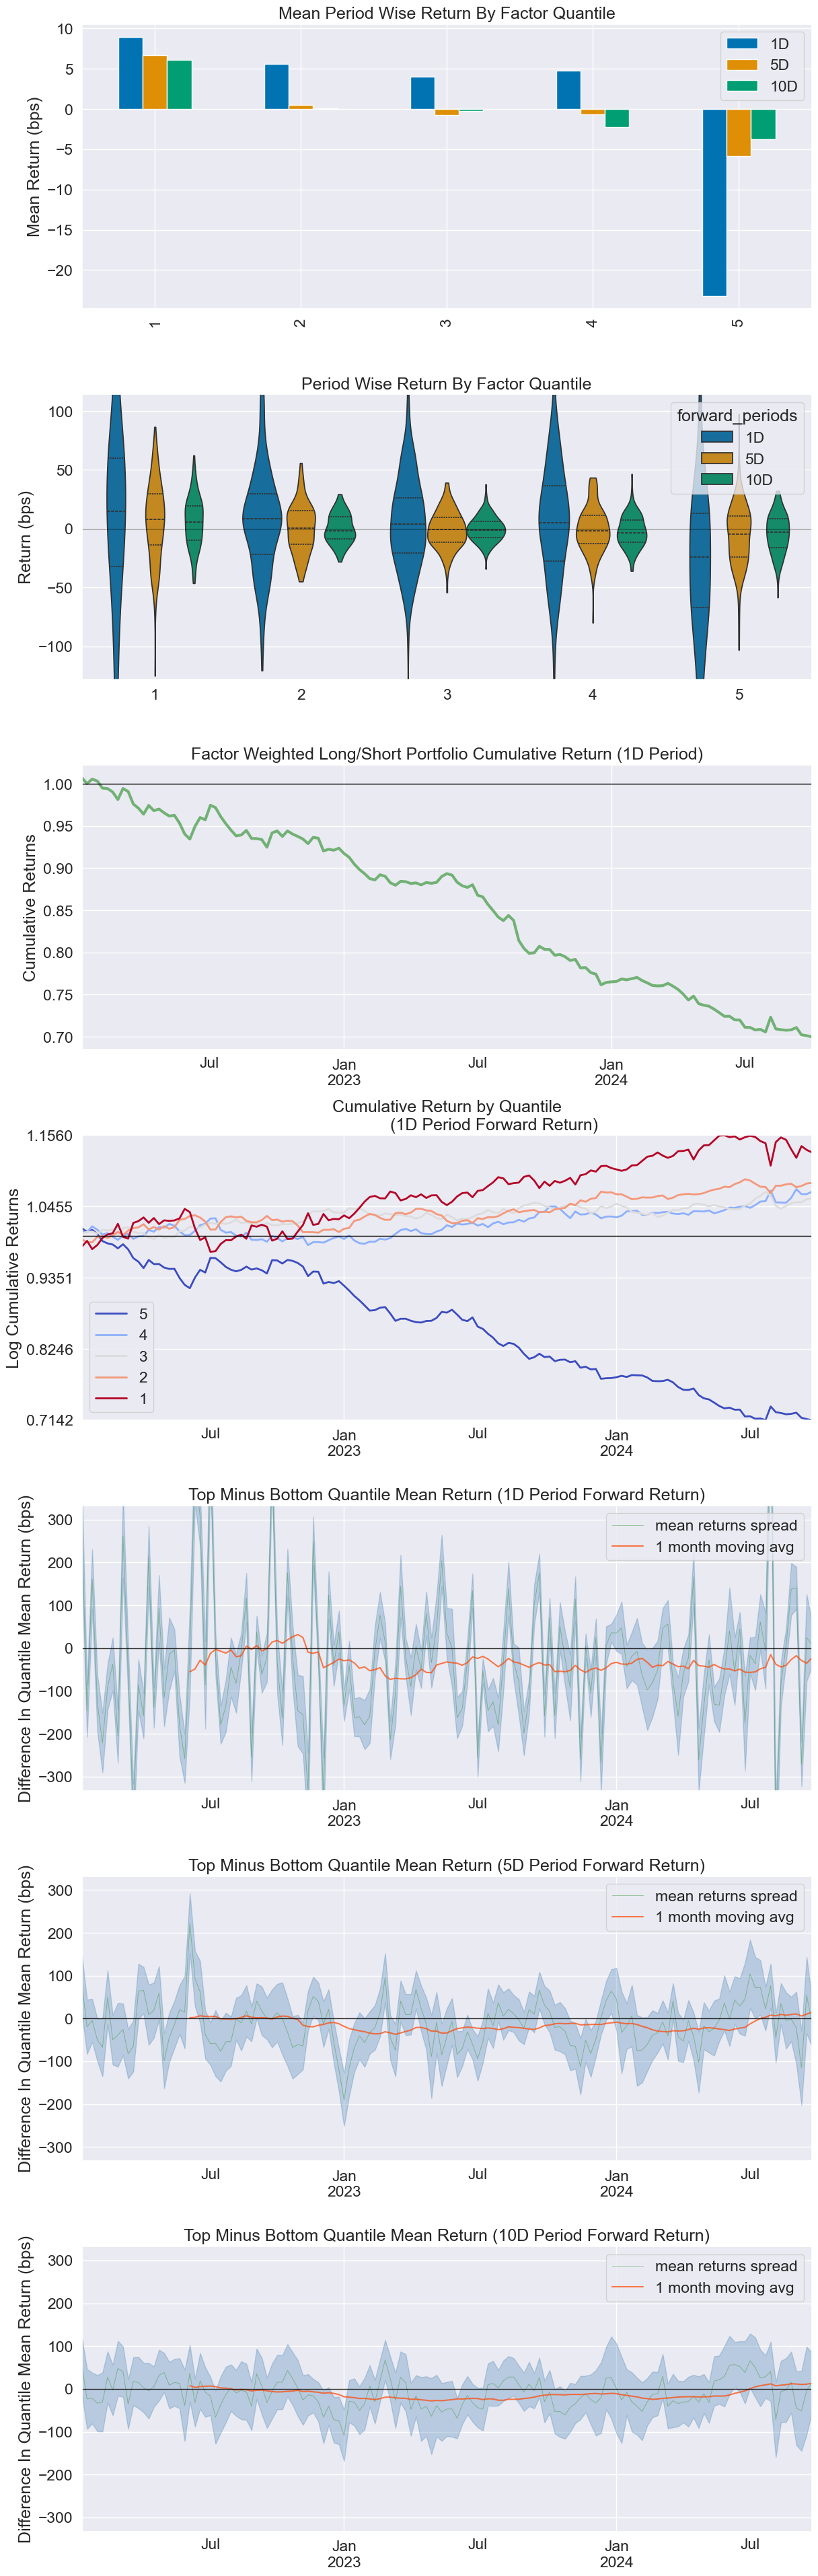

In [9]:
al.tears.create_returns_tear_sheet(factor_data)

Information Analysis


,1D,5D,10D
IC Mean,-0.023,-0.014,-0.015
IC Std.,0.137,0.108,0.095
Risk-Adjusted IC,-0.169,-0.128,-0.159
t-stat(IC),-2.017,-1.528,-1.904
p-value(IC),0.046,0.129,0.059
IC Skew,0.417,0.092,-0.048
IC Kurtosis,0.484,0.936,-0.217


<Figure size 640x480 with 0 Axes>

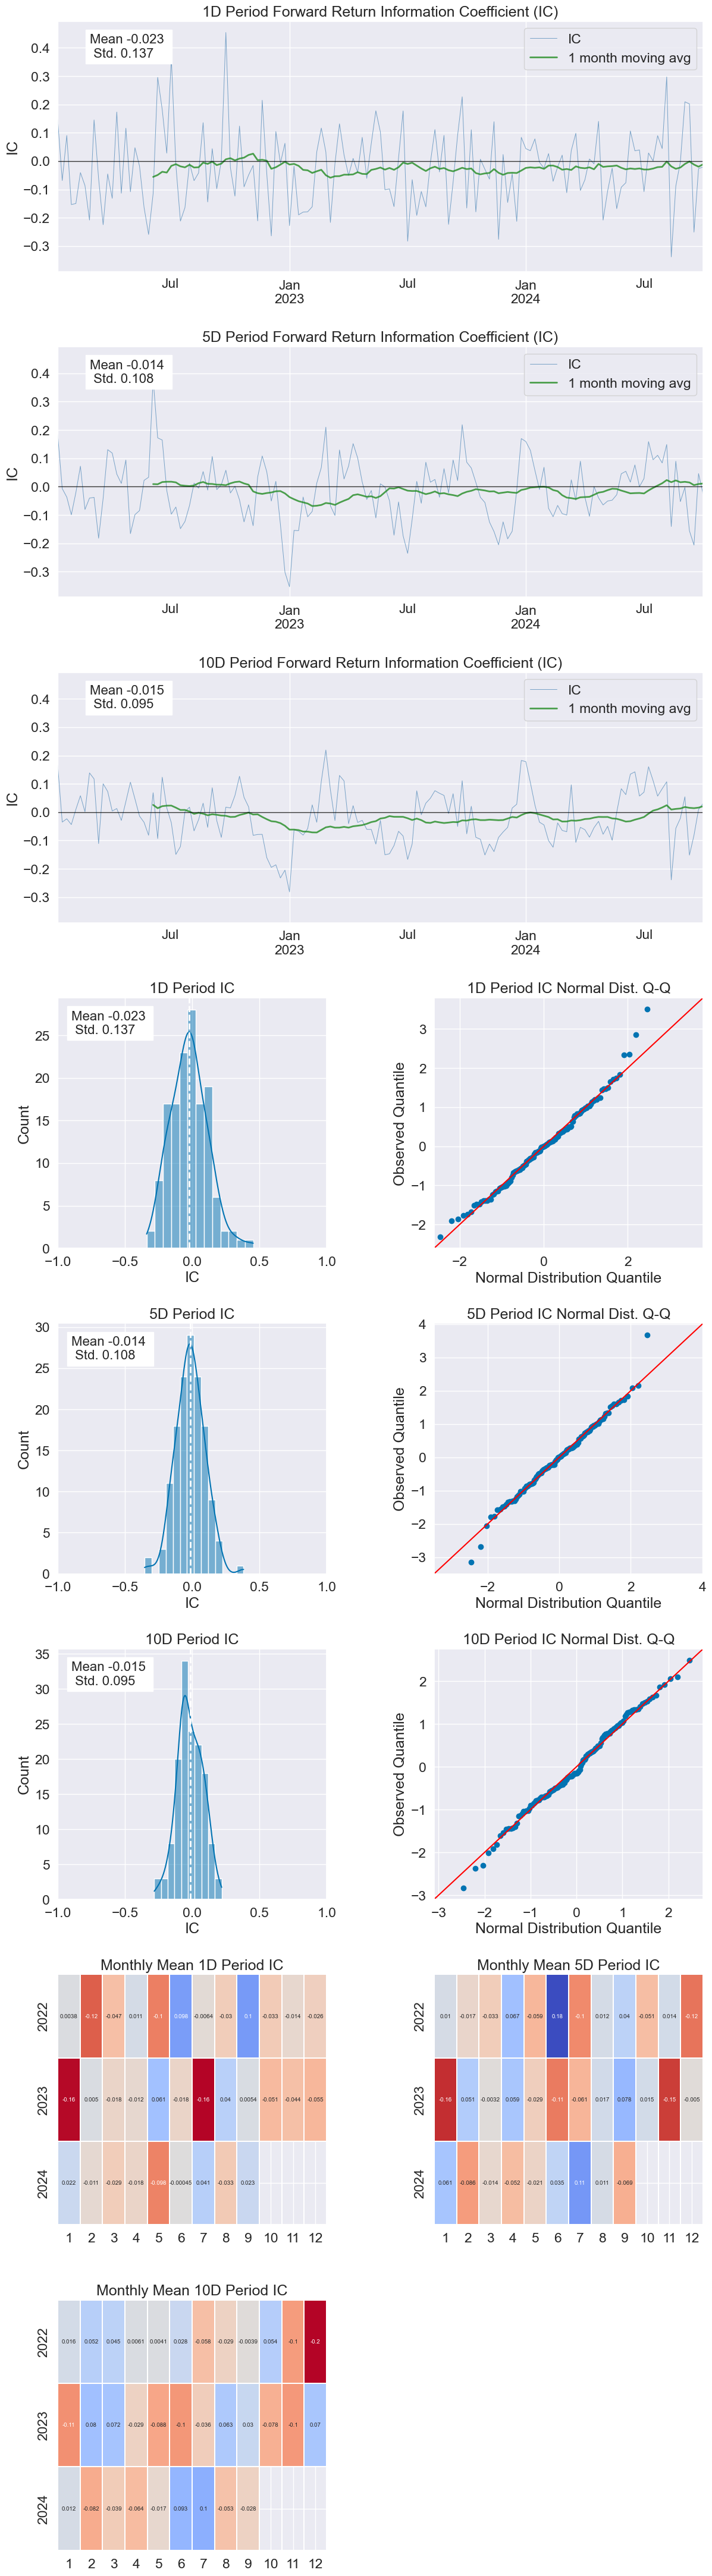

In [10]:
al.tears.create_information_tear_sheet(factor_data)

Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.702,0.700,0.703
Quantile 2 Mean Turnover,0.789,0.785,0.787
Quantile 3 Mean Turnover,0.792,0.793,0.797
Quantile 4 Mean Turnover,0.776,0.774,0.786
Quantile 5 Mean Turnover,0.755,0.739,0.742


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.165,0.182,0.175


<Figure size 640x480 with 0 Axes>

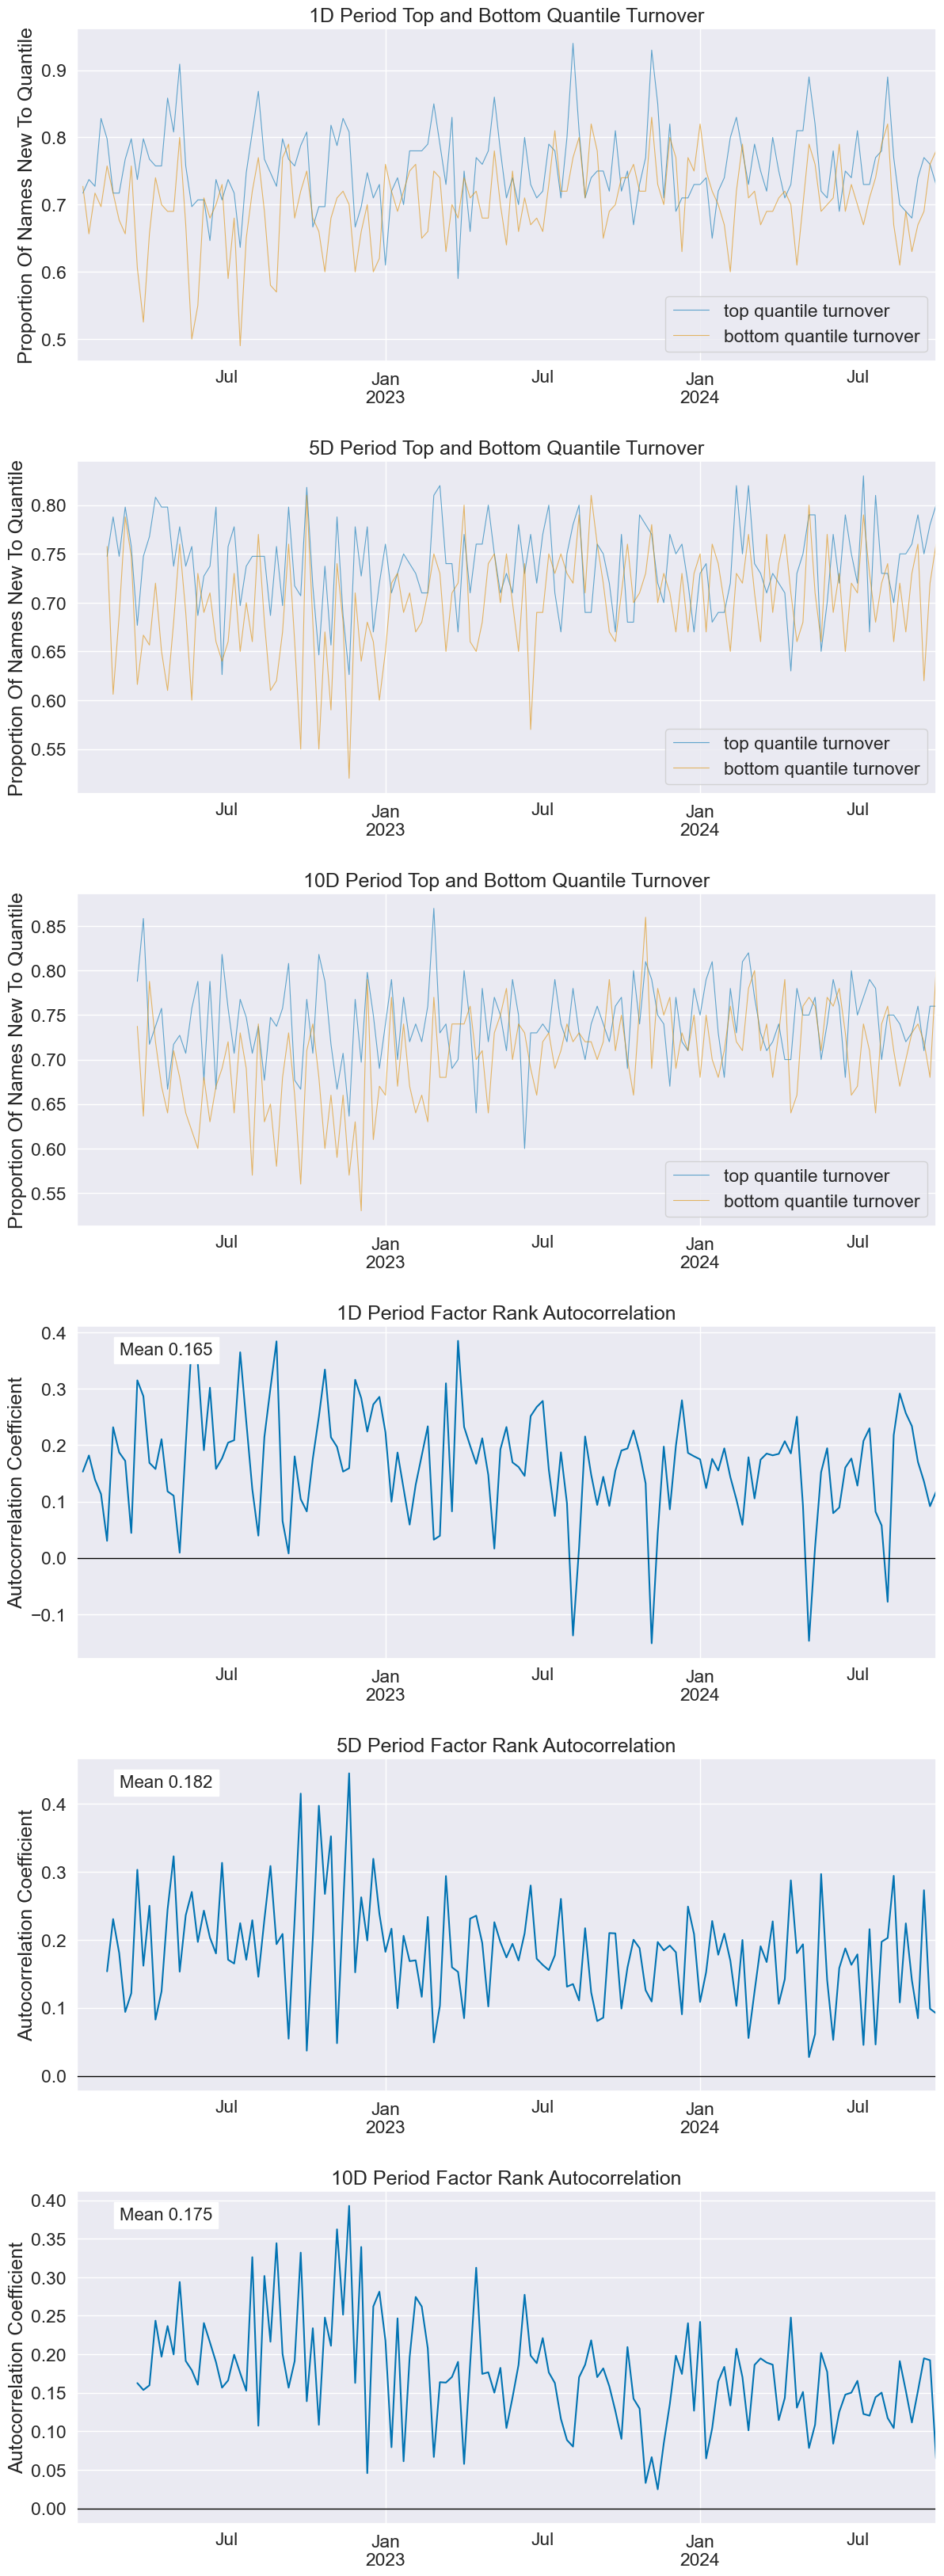

In [11]:
al.tears.create_turnover_tear_sheet(factor_data)